In [3]:
!pip install gdown 
!gdown --id 1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr


/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr
From (redirected): https://drive.google.com/uc?id=1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr&confirm=t&uuid=74b6b6b6-2014-42f3-b9f8-46f93d3c3bf5
To: /kaggle/working/Dataset.zip
100%|█████████████████████████████████████████| 829M/829M [00:05<00:00, 158MB/s]


In [4]:
%cd /kaggle/working

/kaggle/working


In [5]:
! unzip Dataset.zip


Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/baomoi.model.bin  
  inflating: Dataset/wikilingual.csv  
  inflating: Dataset/vietnews_train.csv  
  inflating: Dataset/vietnews_val.csv  
  inflating: Dataset/vietnews_test.csv  


# **Import libraries**

In [6]:
import os
import pickle

import pandas as pd
import numpy as np
import time
import math
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from pyvi import ViTokenizer, ViPosTagger
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Process data**

In [14]:
train = pd.read_csv("Dataset/vietnews_train.csv",index_col = 0)
val = pd.read_csv("Dataset/vietnews_val.csv", index_col = 0)
test = pd.read_csv("Dataset/vietnews_test.csv", index_col = 0)

In [17]:
train.drop(['file'], axis = 1, inplace = True)
val.drop(['file'], axis = 1, inplace = True)
test.drop(['file'], axis = 1, inplace = True)

In [18]:
def process(str):
    return '_sos_ ' + str.lower() + ' _eos_'

In [19]:
train = train.apply(process)
val = val.apply(process)
test = test.apply(process)


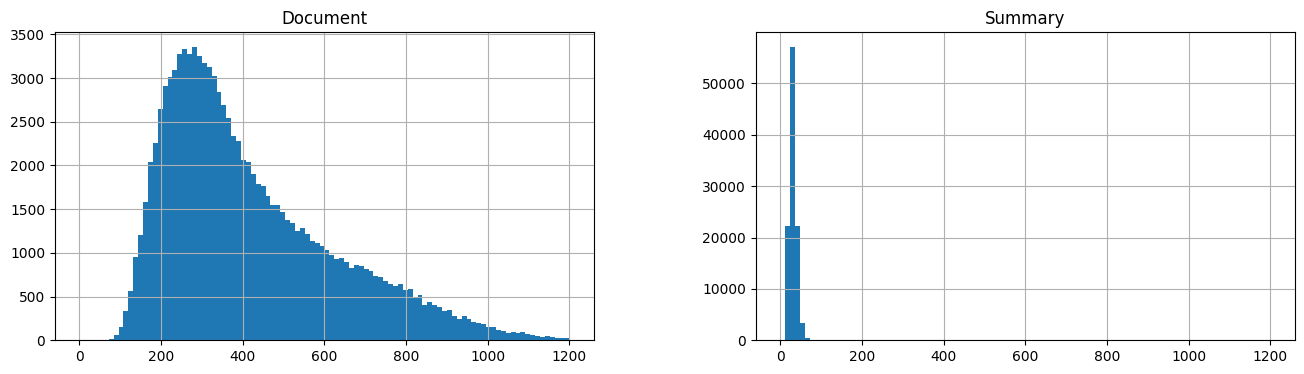

In [20]:
text_count = [len(sentence.split()) for sentence in train.original]
headlines_count = [len(sentence.split()) for sentence in train.summary]

pd.DataFrame({'Document': text_count, 'Summary': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 1200])
plt.show()


In [21]:
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)

print(get_word_percent(train.original, 800))

print(get_word_percent(train.summary, 50))


0.93
0.98


In [22]:
max_text_len = 800
max_summary_len = 50

def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['original'])
    cleaned_summary = np.array(df['summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


train = trim_text_and_summary(train, max_text_len, max_summary_len)
val = trim_text_and_summary(val, max_text_len, max_summary_len)
test = trim_text_and_summary(test, max_text_len, max_summary_len)

print(f'Dataset size: {len(train)}')
train.sample(5)


Dataset size: 96388


,text,summary
27470,_sos_ Xe tay ga của nạn_nhân bị vò nát sau khi...,_sos_ Sau khi gây tai_nạn khiến một phụ_nữ bị_...
63527,_sos_ Sau khi tàu_chiến Mỹ phóng tên_lửa hành_...,"_sos_ Ngoài tên_lửa hành_trình , quân_đội Mỹ c..."
57553,"_sos_ Ông Nguyễn_Thái_Bình , Chánh_Văn_phòng B...","_sos_ Ông Nguyễn_Đăng_Chương , nguyên Cục_trưở..."
86788,_sos_ Những chuyện đầu_tư dự_án kém hiệu_quả c...,_sos_ Trong số 13 dự_án đầu_tư ra nước_ngoài c...
95055,_sos_ Sơ_đồ làng đình_chiến Panmunjom ( Bàn_Mô...,"_sos_ Xen giữa phiên họp sáng và chiều , lãnh_..."


In [24]:
x_train,y_train = train.text, train.summary
x_val,y_val = val.text, val.summary
x_test,y_test = test.text, test.summary


In [25]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)
x_test_sequence = x_tokenizer.texts_to_sequences(x_test)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')
x_test_padded = pad_sequences(x_test_sequence, maxlen=max_text_len, padding='post')

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)
y_test_sequence = y_tokenizer.texts_to_sequences(y_test)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')
y_test_padded = pad_sequences(y_test_sequence, maxlen=max_summary_len, padding='post')


# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1
y_vocab_size = len(y_tokenizer.word_index) + 1
# else use this
# x_vocab_size = tokenizer.num_words + 1

print(y_vocab_size)


21946


In [26]:
SOS_token = y_tokenizer.word_index['sos']
EOS_token = y_tokenizer.word_index['eos']
print("SOS token: ",SOS_token)
print("EOS token: ",EOS_token)


SOS token:  1
EOS token:  2


In [27]:
embedding_size = 400
word_vectors = KeyedVectors.load_word2vec_format('Dataset/baomoi.model.bin', binary=True)
num_words_x = len(x_tokenizer.word_index) + 1
x_embedding_matrix = np.zeros((num_words_x, embedding_size))
for word, i in x_tokenizer.word_index.items():
    if word in word_vectors:
        x_embedding_matrix[i] = word_vectors[word]
    else:
        x_embedding_matrix[i] = np.random.normal(size=(embedding_size,))
num_words_y = len(y_tokenizer.word_index) + 1
y_embedding_matrix = np.zeros((num_words_y, embedding_size))
for word, i in y_tokenizer.word_index.items():
    if word in word_vectors:
        y_embedding_matrix[i] = word_vectors[word]
    else:
        y_embedding_matrix[i] = np.random.normal(size=(embedding_size,))


In [28]:
import torch.utils.data as data

train_dataset = data.TensorDataset(torch.tensor(x_train_padded,dtype = torch.long).to(device), torch.tensor(y_train_padded,dtype = torch.long).to(device))
train_dataloader = data.DataLoader(train_dataset, batch_size = 64, shuffle= True)
val_dataset = data.TensorDataset(torch.tensor(x_val_padded,dtype = torch.long).to(device), torch.tensor(y_val_padded,dtype = torch.long).to(device))
val_dataloader = data.DataLoader(val_dataset, batch_size = 64, shuffle= True)
test_dataset = data.TensorDataset(torch.tensor(x_test_padded,dtype = torch.long).to(device), torch.tensor(y_test_padded,dtype = torch.long).to(device))
test_dataloader = data.DataLoader(test_dataset, batch_size = 64, shuffle= True)

# **Modelling**

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, embedding_weight):
        super().__init__()
        
        # initializations
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weight, dtype= torch.float32),requires_grad= False)
        # we will use 2 layers for both encoder and decoder
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return outputs, hidden, cell
 



class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,embedding_weight):
        super().__init__()
        
        # initialize
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weight, dtype= torch.float32),requires_grad= False)

        # for decoder we will use n_directions 1
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        # fully connected layer to predict words
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, hidden, cell):
        
        #trg = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        trg = trg.unsqueeze(0)
        
        #trg = [1, batch size]
        
        embedded = self.dropout(self.embedding(trg))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, embedding_weight):
        super().__init__()
        
        # initialize
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weight, dtype=torch.float32), requires_grad=False)

        # for decoder we will use n_directions 1
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        # fully connected layer to predict words
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hid_dim * 2, 1)

    def forward(self, trg, hidden, cell, encoder_outputs):
        # trg = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]

        # n directions in the decoder will always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]

        trg = trg.unsqueeze(0)

        # trg = [1, batch size]

        embedded = self.dropout(self.embedding(trg))

        # embedded = [1, batch size, emb dim]

        # Calculate attention scores
        attn_scores = self.attention(torch.cat((hidden[-1].unsqueeze(0).repeat(encoder_outputs.shape[0], 1, 1), encoder_outputs), dim=-1))

        # Convert scores to weights
        attn_weights = F.softmax(attn_scores, dim=0)

        # Apply attention weights to encoder outputs
        context = torch.sum(attn_weights * encoder_outputs, dim=0)

        # context = [batch size, hid dim]

        rnn_input = torch.cat((embedded, context.unsqueeze(0)), dim=-1)

        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0))

        # prediction = [batch size, output dim]

        return prediction, hidden, cell
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size] where src_len is number of tokens in source sentence
        #trg = [trg len, batch size] same for trg_len
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim # we don't have trg.shape[-1] here
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(dec_input, hidden, cell, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            dec_input = trg[t] if teacher_force else top1
        
        return outputs
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size] where src_len is number of tokens in source sentence
        #trg = [trg len, batch size] same for trg_len
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim # we don't have trg.shape[-1] here
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        _, hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(dec_input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            dec_input = trg[t] if teacher_force else top1
        
        return outputs


In [29]:
from tqdm import tqdm
import time
import math
class Seq2Seq_trainer(object):
    def __init__(self, model, train_iterator, valid_iterator, pad_index, device, clip, learning_rate):
        # initialize config variables
        self.model = model.to(device)
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator
        self.clip = clip
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
        self.criterion = nn.CrossEntropyLoss(ignore_index = pad_index)
        self.model.apply(self.init_weights)
        print(f'The model has {self.count_parameters(self.model):,} trainable parameters')

        
    
    def init_weights(self,m):
        for name, param in m.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)
        
    
    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
    def train(self):

        self.model.train()

        epoch_loss = 0

        for i, batch in enumerate(self.train_iterator):

            src = batch[0].transpose(0, 1)
            trg = batch[1].transpose(0, 1)


            self.optimizer.zero_grad()

            output = self.model(src, trg)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = self.criterion(output, trg)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)

            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(self.train_iterator)
    
    
    def evaluate(self, iterator):

        self.model.eval()

        epoch_loss = 0

        with torch.no_grad():

            for i, batch in enumerate(iterator):

                src = batch[0].transpose(0, 1)
                trg = batch[1].transpose(0, 1)

                output = self.model(src, trg, 0) #turn off teacher forcing

                #trg = [trg len, batch size]
                #output = [trg len, batch size, output dim]

                output_dim = output.shape[-1]

                output = output[1:].view(-1, output_dim)
                trg = trg[1:].reshape(-1)

                #trg = [(trg len - 1) * batch size]
                #output = [(trg len - 1) * batch size, output dim]

                loss = self.criterion(output, trg)

                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    
    def fit(self, nepochs):
        best_valid_loss = float('inf')

        for epoch in tqdm(range(nepochs)):

            start_time = time.time()

            train_loss = self.train()
            valid_loss = self.evaluate(self.valid_iterator)

            end_time = time.time()

            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                # torch.save(model.state_dict(), 'tut1-model.pt')
                print(f'Epoch with best validation loss: {epoch+1:02}')

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

            
    def predict(self, iterator):
        self.model.eval()

        with torch.no_grad():

            for i, batch in enumerate(tqdm(iterator)):

                src = batch[0].transpose(0, 1)
                trg = batch[1].transpose(0, 1)

                output = self.model(src, trg, 0) #turn off teacher forcing

                #trg = [trg len, batch size]
                #output = [trg len, batch size, output dim]
                
                if i == 0:
                    outputs = torch.argmax(output, -1)
                else:
                    outputs = torch.cat((outputs, torch.argmax(output, -1)), -1)
                
                # outputs = [trg_len, len(iterator)]
        return torch.transpose(outputs, 0, 1)


# **Normal Seq2seq: BiLSTM without attention**

In [34]:
INPUT_DIM = x_vocab_size
OUTPUT_DIM = y_vocab_size
ENC_EMB_DIM = 400
DEC_EMB_DIM = 400
HID_DIM = 400
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# initialize seq2seq model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT,x_embedding_matrix)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT,y_embedding_matrix)
model = Seq2Seq(enc, dec, device)


In [35]:
pad_index = 0
# initialize trainer
normal_trainer = Seq2Seq_trainer(model, train_dataloader, val_dataloader, pad_index, device, 1, 1e-3)

The model has 13,933,146 trainable parameters


In [36]:
normal_trainer.fit(5)

 20%|██        | 1/5 [23:28<1:33:55, 1408.76s/it]

Epoch with best validation loss: 01
Epoch: 01 | Time: 23m 28s
	Train Loss: 6.903 | Train PPL: 995.432
	 Val. Loss: 6.957 |  Val. PPL: 1050.822


 40%|████      | 2/5 [46:56<1:10:25, 1408.37s/it]

Epoch: 02 | Time: 23m 28s
	Train Loss: 6.445 | Train PPL: 629.277
	 Val. Loss: 7.070 |  Val. PPL: 1175.749


 60%|██████    | 3/5 [1:10:22<46:54, 1407.33s/it]

Epoch: 03 | Time: 23m 26s
	Train Loss: 6.156 | Train PPL: 471.458
	 Val. Loss: 7.027 |  Val. PPL: 1126.866


 80%|████████  | 4/5 [1:33:51<23:27, 1407.69s/it]

Epoch: 04 | Time: 23m 28s
	Train Loss: 5.992 | Train PPL: 400.022
	 Val. Loss: 7.017 |  Val. PPL: 1115.585


100%|██████████| 5/5 [1:57:23<00:00, 1408.60s/it]

Epoch with best validation loss: 05
Epoch: 05 | Time: 23m 31s
	Train Loss: 5.869 | Train PPL: 353.955
	 Val. Loss: 6.934 |  Val. PPL: 1026.821


In [37]:
test_loss = normal_trainer.evaluate(test_dataloader)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')


	 Test. Loss: 6.927 |  Test. PPL: 1019.291


In [38]:
test_tensor = normal_trainer.predict(test_dataloader)
test_out = test_tensor.to('cpu').numpy()


100%|██████████| 323/323 [01:44<00:00,  3.09it/s]


In [39]:
def get_sentence(arr, y_tokenizer):
  output = ''
  for element in arr:
    if element != 0:
      output = output + y_tokenizer.index_word[element] + ' '
  return output

In [40]:
print("Text: ", x_test[14])
print("Predict summary: ", get_sentence(test_out[14], y_tokenizer))
print("True summary: ", y_test[14])

Text:  _sos_ Khoảng 7h ngày 11/5 , xe_tải biển kiểm_soát Hà_Tĩnh chạy hướng Sơn_La - Hà_Nội trên quốc_lộ 6 , khi đến dốc Cun ( tỉnh Hoà_Bình ) thì tài_xế mất lái khiến xe va_chạm với ôtô bảy chỗ biển Hà_Nội chạy chiều ngược_lại . Xe_tải sau đó tiếp_tục lao xuống dốc , va_chạm với một xe_tải khác biển Hà_Nội khiến xe này bị lật ngang , đè lên một xe_máy . Hiện_trường vụ tai_nạn . Tại hiện_trường , ôtô bảy chỗ bị húc văng vào sườn đồi , xe_tải lật nghiêng , các mảnh vỡ từ phương_tiện văng vung_vãi . Người điều_khiển ôtô bảy chỗ tử_vong , hai người khác bị_thương nặng được đưa đi bệnh_viện cấp_cứu . Quốc_lộ 6 đoạn qua dốc Cun ách_tắc nhiều giờ . Lực_lượng chức_năng đã có_mặt để phân_luồng giao_thông , làm rõ nguyên_nhân tai_nạn . Gia_Chính   Hiện_trường vụ tai_nạn .  _eos_
Predict summary:  sau khi bị công an đã bị bắt giữ một người đàn ông bị bị bị bị thương trong một người eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos 
Tr

# **Attention Seq2seq: BiLSTM with attention**

In [32]:
INPUT_DIM = x_vocab_size
OUTPUT_DIM = y_vocab_size
ENC_EMB_DIM = 400
DEC_EMB_DIM = 400
HID_DIM = 400
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# initialize seq2seq model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, x_embedding_matrix)
dec = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, y_embedding_matrix)
attn_model = AttnSeq2Seq(enc, dec, device)

pad_index = 0
# initialize trainer
attn_trainer = Seq2Seq_trainer(attn_model, train_dataloader, val_dataloader, pad_index, device, 1, 1e-3)

The model has 14,573,947 trainable parameters


In [33]:
attn_trainer.fit(5)

 20%|██        | 1/5 [37:05<2:28:21, 2225.45s/it]

Epoch with best validation loss: 01
Epoch: 01 | Time: 37m 5s
	Train Loss: 6.956 | Train PPL: 1049.296
	 Val. Loss: 6.927 |  Val. PPL: 1019.349


 40%|████      | 2/5 [1:14:16<1:51:25, 2228.57s/it]

Epoch with best validation loss: 02
Epoch: 02 | Time: 37m 10s
	Train Loss: 6.578 | Train PPL: 719.115
	 Val. Loss: 6.768 |  Val. PPL: 869.892


 60%|██████    | 3/5 [1:51:28<1:14:20, 2230.30s/it]

Epoch with best validation loss: 03
Epoch: 03 | Time: 37m 12s
	Train Loss: 6.131 | Train PPL: 459.740
	 Val. Loss: 6.660 |  Val. PPL: 780.553


 80%|████████  | 4/5 [2:28:38<37:10, 2230.31s/it]  

Epoch with best validation loss: 04
Epoch: 04 | Time: 37m 10s
	Train Loss: 5.866 | Train PPL: 352.786
	 Val. Loss: 6.554 |  Val. PPL: 701.899


100%|██████████| 5/5 [3:05:49<00:00, 2229.86s/it]

Epoch with best validation loss: 05
Epoch: 05 | Time: 37m 10s
	Train Loss: 5.686 | Train PPL: 294.662
	 Val. Loss: 6.527 |  Val. PPL: 683.425


In [41]:
test_loss = attn_trainer.evaluate(test_dataloader)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')


	 Test. Loss: 6.520 |  Test. PPL: 678.254


In [42]:
test_tensor = attn_trainer.predict(test_dataloader)
test_out_attn = test_tensor.to('cpu').numpy()


100%|██████████| 323/323 [02:11<00:00,  2.45it/s]


In [53]:
test_out_attn[4]

array([   0,   25,   20,   37,    9,    5,  415,   38,   15,    5,  415,
         38,    7,  335,  765,  525,   27,   24, 1597,    8,   44,    7,
         12,    8,   44,    7,   12,    8,   44,    7,   12,    8,   44,
          7,   12,  152,  296,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2])

In [46]:
print("Text: ", x_test[4])
print("Predict summary: ", get_sentence(test_out_attn[4], y_tokenizer))
print("True summary: ", y_test[4])

Text:  _sos_ Sau khi đẻ rơi trên đường , mẹ con sản_phụ Nguyễn_Thị_Hằng được 2 thanh_niên cùng quê chở đến bệnh_viện , hiện sức_khoẻ bình_phục . Ảnh : Giang_Chinh 2h ngày 28/4 , chị Nguyễn_Thị_Hằng ( 26 tuổi , trú xã Tân_Dương , Thuỷ_Nguyên , TP Hải_Phòng ) kêu đau đẻ , được chồng chở bằng xe_máy đến Bệnh_viện Đa_khoa huyện Thuỷ_Nguyên . Ra khỏi nhà khoảng 2 km , chị Hằng trở_dạ và sinh luôn trên đường , đoạn thuộc khu_phố Mới , xã Thuỷ_Sơn . Trong đêm_tối , người chồng để vợ nằm xuống đất và đỡ_đẻ . Bé gái 3,3 kg chào_đời khoẻ_mạnh . Không gọi được taxi cũng như xe cấp_cứu , người chồng ôm con đứng vẫy ôtô qua_lại , nhưng không ai dừng xe . Bà Văn_Thị_Thoa , mẹ chị Hằng kể , khi đi xe_máy đến_nơi , bà thấy con đã sinh , nằm sõng_soài dưới đất , còn chồng ủ ấm cho cháu bé . Hai mẹ_con vẫy xe nhưng không được . " Tôi đã nghĩ nếu không có xe , trời mưa nặng hạt hơn sẽ phải gõ_cửa , làm_phiền nhà dân thì chiếc ôtô màu đen chạy tới . 2 thanh_niên trên xe bước xuống , hỏi chuyện , rồi đưa 2